# Semantic Segmentation Tutorial

De acordo com [Harshall Lamba] (https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47), o objetivo da segmentação semântica é rotular cada pixel de uma imagem a uma classe correspondente. Como estamos prevendo para cada pixel da imagem, essa tarefa geralmente é chamada de previsão densa:

![image](https://user-images.githubusercontent.com/32513366/80520367-b3d1f000-895f-11ea-80fd-2c11a2ecf7f8.png)

O *notebook* apresentado aqui busca mostrar de forma simples em português a temática abordado. Vale ressaltar que o material usado como base foi o [tensorflow segmentation tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

## Sumário

Este *notebook* é divido em:
- Importando os dados
- Pré-processamento
- Modelo de Deep Learning: UNet
- Treinando o modelo
- Avaliação de desempenho
- Avaliação qualitativa do modelo
- Conclusões


## Módulos

In [1]:
# Básico
import numpy as np

# Deep Learning
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Plot 
import matplotlib.pyplot as plt

In [2]:
# Comandos úteis para o notebook
tfds.disable_progress_bar()
%matplotlib inline

# Importando os dados

In [3]:
# Importar dados com informações
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
# Separar conjunto de treino e teste
train_dataset = dataset['train']
test_dataset = dataset['test']

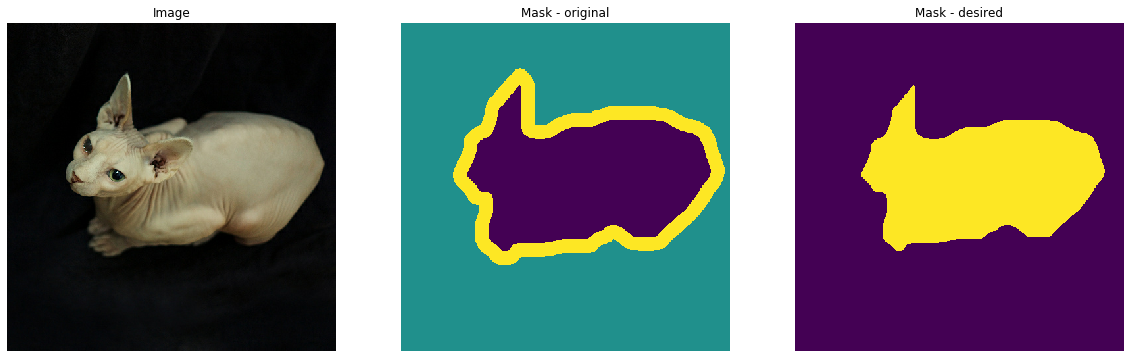

In [5]:
# Pegar uma amostra do banco de dados para fazer plot
for example in train_dataset.take(1):
    image, mask = example["image"].numpy(), example["segmentation_mask"].numpy()
    mask2 = mask.copy()
    mask2[(mask2 == 2) | (mask2 == 3)] = 0

# Plot
fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].imshow(tf.keras.preprocessing.image.array_to_img(image))
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
ax[1].set_title('Mask - original')
ax[1].axis('off')
ax[2].imshow(tf.keras.preprocessing.image.array_to_img(mask2))
ax[2].set_title('Mask - desired')
ax[2].axis('off');

Como você pode ver, o conjunto de dados original apresenta três classes:
- Não é um animal
- Limites do animal
- É um animal

Meu objetivo aqui é trabalhar com apenas duas classes:
- *Não é um animal*
- *É um animal*

Para fazer isso, na minha fase **Pré-processamento**, desenvolvi uma função para mesclar as classes:
- Não é um animal
- Limites do animal

Em uma só!

# Pré-processamento
Usando o **Data API** do `tensorflow_datasets`, o pré-processamento e *data augmentation* são aplicados através da chamada de uma função pelo `.map()`. Você pode aplicar essa chamada para todas as funções apresentadas abaixo separadamente, mas na minha implementação eu optei por criar uma função geral para tornar o código mais limpo. Esta função consistirá em um pipeline.

## Funções - Pré-processamento

In [6]:
def resize_normalize_data(image, segmentation_mask):
    # Resize imagem e segmentation mask
    image = tf.image.resize(image, (128, 128))
    segmentation_mask = tf.image.resize(segmentation_mask, (128, 128))
    # Retorna uma imagem normalizada no intervalo [0, 1] e a mask
    return tf.image.convert_image_dtype(image, tf.float32)/255, segmentation_mask

In [7]:
def change_segmentation_mask(segmentation_mask):
    # Definir as classes como zero
    segmentation_mask = tf.where((segmentation_mask == 2) | (segmentation_mask == 3), 0, 1)
    # Return mask com valores inteiros
    return tf.cast(segmentation_mask, tf.uint8)

## Funções - *Data Augmentation*

In [8]:
def data_aug_flip_left_right(image, segmentation_mask):
    # Avaliar randomicamente a possibilidade de girar a imagem
    if tf.random.uniform(()) > 0.5:
        return tf.image.flip_left_right(image), tf.image.flip_left_right(segmentation_mask)
    else:
        return image, segmentation_mask

In [9]:
def data_aug_contrast(image):
    # Retorna aleatoriamente uma imagem com contraste diferente
    return tf.image.random_contrast(image, lower=0.0, upper=0.8)

## Funções - Pipelines para conjunto de treinamento e teste

### Passos - Treinamento
- Alterar a mascara de segmentação original para uma mascara binária
- Redimensionar a imagem/mascara & normalizar a imagem
- Data Augmentation 1: Randomicamente girar a imagem/mask
- Data Augmentation 2: randomicamente adicionar contraste na imagem

In [10]:
def pre_processing_train(datapoint):
    img = datapoint['image']
    seg = datapoint['segmentation_mask']
    # Alterar a mascara de segmentação original para uma mascara binária
    seg = change_segmentation_mask(seg)
    # Redimensionar a imagem/mascara & normalizar a image
    img, seg = resize_normalize_data(img, seg)
    # Data Augmentation 1: Randomicamente girar a imagem/mask
    img, seg = data_aug_flip_left_right(img, seg)
    # Data Augmentation 2: randomicamente adicionar contraste na imagem
    img = data_aug_contrast(img)
    # Retornar
    return img, seg    

### Passos - Teste
- Alterar a mascara de segmentação original para uma mascara binária
- Redimensionar a imagem/mascara & normalizar a imagem

In [11]:
def pre_processing_test(datapoint):
    img = datapoint['image']
    seg = datapoint['segmentation_mask']
    # Alterar a mascara de segmentação original para uma mascara binária
    seg = change_segmentation_mask(seg)
    # Redimensionar a imagem/mascara & normalizar a imagem
    img, seg = resize_normalize_data(img, seg)
    # Return call
    return img, seg

## Fatores para Pré-processamento

Cada fator presente aqui é necessário para entender como o `` tensorflow_datasets`` irá processar o seu conjunto de dados:

- ```BATCH_SIZE```: quantidade de amostras necessárias para atualizar os pesos através do *Backpropagation*. Após atingir essa quantidade, o gradiente será calculado em relação à **média dos erros da função custo**.
- ```BUFFER_SIZE```: argumento específico da implementação do tensorflow. Relacionado a chamada `.shuffle ()`, define o número de elementos do conjunto de dados (amostras) a serem armazenados na memória e **aleatoriamente** selecionados para compor outro conjunto.
Para obter mais informações, acesse esta [resposta do stackoverflow] (https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle).

In [12]:
# Fatores
BATCH_SIZE = 64
BUFFER_SIZE = 1000

## Processo de pré-processamento do banco de dados

Para prosseguir com o processo de pré-processamento do conjunto de dados através de ``tensorflow_datasets``, é necessário entender algumas funções utilizadas aqui:
- ``.map()``: Aplica uma **map_function** para cada elemento no seu conjunto de dados.
- ``.cache()``: basicamente armazena em cache os elementos do conjunto de conjunto de dados. Segundo a  *docstring*: "*Na primeira vez em que o conjunto de dados é iterado, seus elementos serão armazenados em cache no arquivo especificado ou na memória. As iterações subsequentes usarão os dados em cache*".
- ``.shuffle()``: Função para **aleatoriamente** embaralhar os elementos desse conjunto de dados. Esta função seleciona um elemento aleatório em um buffer de tamanho fixo **BUFFER_SIZE**. É importante observar que, de acordo com a documentação do tensorflow, para um **BUFFER_SIZE** < **len(conjunto de dados)** seu buffer é feito sequencialmente. Por exemplo: dado **BUFFER_SIZE** de 10 em um conjunto de dados com comprimento de 100, a função criará um buffer que obtém os 10 primeiros elementos (**sequencialmente**) e escolhe aleatoriamente um deles para compor um Batch por exemplo, depois o 11º elemento do conjunto de dados substituirá o lugar vazio. Logo o buffer nunca estará com dado faltante.
- ``.batch()``: Cria pacotes (*mini-batches*) com tamanho de **BATCH_SIZE** para os primeiros elementos encontrados.
- ``.repeat()``: Função para repetir esse conjunto de dados para que cada valor original seja visto **count** vezes. Se nenhum argumento for passado, será repetido indefinidamente.
- ``.prefetch()``: Cria um conjunto de dados que pré-busca elementos deste conjunto de dados. A maioria dos pipelines de entrada do conjunto de dados deve terminar com uma chamada para `prefetch`. Isso permite que elementos posteriores sejam preparados enquanto o elemento atual está sendo processado. Isso geralmente melhora a latência e a taxa de transferência, com o custo de usar memória adicional para armazenar elementos pré-buscados.

É importante entender que as chamadas de pedidos podem alterar completamente o procedimento!

### Links Úteis
- [Entenda o método .shuffle()] (https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)

### Procedimento para o conjunto de treinamento

In [13]:
train_dataset = train_dataset.map(map_func=pre_processing_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Procedimento para o conjunto de teste

In [14]:
test_dataset = test_dataset.map(map_func=pre_processing_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Visualização dos dados após o pré-processamento

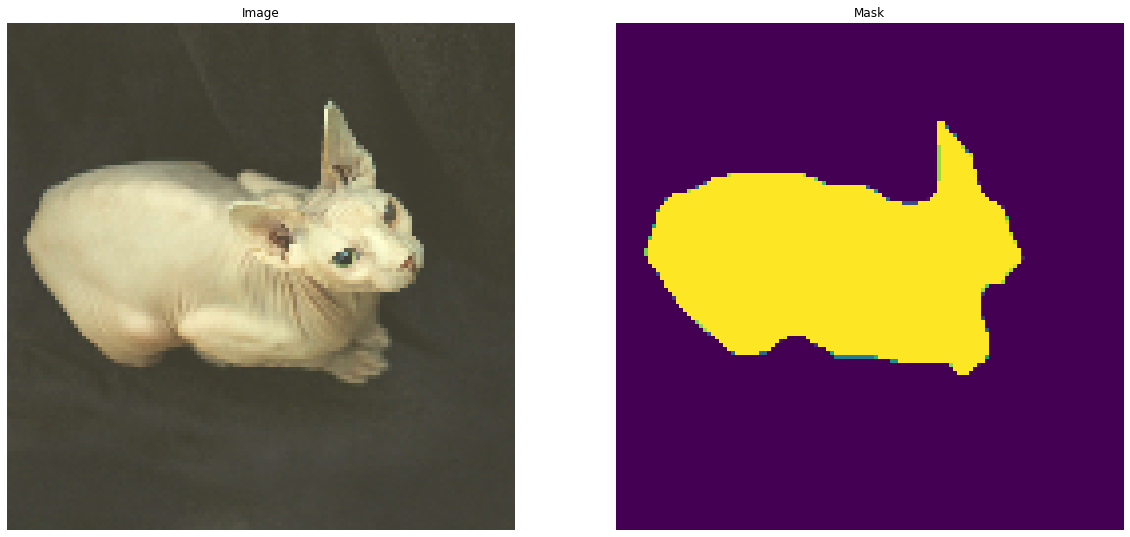

In [15]:
for img, seg in train_dataset.take(1):
    image, mask = img[0], seg[0]

# Plot
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(tf.keras.preprocessing.image.array_to_img(image))
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
ax[1].set_title('Mask')
ax[1].axis('off');

# Modelo de Deep Learning: UNet
A partir daqui, meu tutorial percorre um caminho diferente do tutorial do tensorflow para segmentação. A ideia é construir um modelo do zero e treina-lo para compreender melhor a sintaxe do ```keras```.

## UNet
A UNet foi proposta em 2015 através do artigo [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597). Sua arquitetura é composta por duas fases:
- Encoder
- Decoder

**Encoder** é responsável por capturar o contexto da imagem e compreender aonde o objetivo poderia estar localizado ao custo da perda de informações espaciais. Já o **Decoder** consiste em ampliar a imagem para recuperar informações espaciais, mas com as informações encontradas na fase anterior (mapas de ativação) para construir a máscara de segmentação. Esta ampliação é realizada através da *Transpose Convolution*.

A imagem abaixo apresenta como é a construção deste modelo [fonte de leitura - Harshall Lamba](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47): 

![image](https://user-images.githubusercontent.com/32513366/80515000-ac0e4d80-8957-11ea-85e5-97aca21f346d.png)

### *Contracting Path*
Formado por "*Encoder blocks*", cada um consiste em:
- Bloco de CNN para extração de característica (*Conv2DBlock*): 
    - Convolutional Layer with kernel of 3x3, stride of 1 and zero padding
    - Batchnormalization
    - ReLU
    - Convolutional Layer with kernel of 3x3, stride of 1 and zero padding
    - Batchnormalization
    - ReLU
- MaxPooling 2x2 with stride of 2
- Dropout layer (Não presente no original, mas adicionada neste tutorial)

### *Expanding Path*
Formado por "*Decoder blocks*", cada um consiste em:
- TransposeConv2D para ampliar a entrada
- Concatenação dos resultados de um *Conv2DBlock* do *Encoder* que apresenta as mesmas dimensões ou seja: largura, altura e canais
- Dropout Layer (Não presente no original, mas adicionada neste tutorial)
- Bloco de CNN para extração de característica (*Conv2DBlock*)

É importante notar que ***Conv2DBlock*** está presente em ambos os caminhos: isso ocorre porque ele apresenta a função de extrair características! Vale lembrar que dado sua implementação, ele não aplica nenhuma redução de dimensionalidade.

## Desenvolvimento do modelo

### Funções - Convolutional 2D Block

In [16]:
def Conv2DBlock(input_block, n_filters, kernel_dims=(3,3), use_batchnorm=True):
    ''' Funcao para criar Conv2D Block (args em ingles)
    Conv layer -> BatchNorm -> ReLU -> Conv layer -> BatchNorm -> ReLU
    Args:
        input_block: input to this block
        n_filters: number of filters in each Conv2D
        kernel_dims: Kernel Dimensions to each convolutional layer
        use_batchnorm: Set False to avoid Batch Normalization Layer.
    '''
    # Conv2D 
    conv2d_block = Conv2D(filters=n_filters, 
                          kernel_size=kernel_dims,
                          kernel_initializer='he_normal',
                          strides=(1,1),
                          padding='same')(input_block)
    # BatchNorm
    if use_batchnorm:
        conv2d_block = BatchNormalization()(conv2d_block)
    # ReLU
    conv2d_block = Activation(activation='relu')(conv2d_block)
    # Conv2D 
    conv2d_block = Conv2D(filters=n_filters,
                          kernel_size=kernel_dims,
                          kernel_initializer='he_normal',
                          strides=(1,1),
                          padding='same')(conv2d_block)
    # BatchNorm
    if use_batchnorm:
        conv2d_block = BatchNormalization()(conv2d_block)
    # ReLU
    conv2d_block = Activation(activation='relu')(conv2d_block)
    # Return Conv2D Block
    return conv2d_block

### Função - Criar UNet

In [17]:
def model_UNet(input_layer, dropout_rate=0.1, use_batchnorm=True):
    '''
    Funcao que retorna modelo UNet (args em ingles)
    Args:
        input_layer: Input object to develop the model
        dropout_rate: rate to drop neurons
        use_batchnorm: Turn False to not use Batch Normalization in Conv2DBlock
    '''
    # ENCODER PATH
    ## E1
    conv_1 = Conv2DBlock(input_block=input_layer, n_filters=16, use_batchnorm=use_batchnorm)
    down_1 = MaxPool2D(name='MaxPool_1', pool_size=(2, 2), strides=2)(conv_1)
    down_1 = Dropout(name='Dropout_1', rate=dropout_rate)(down_1)
    ## E2
    conv_2 = Conv2DBlock(input_block=down_1, n_filters=32, use_batchnorm=use_batchnorm)
    down_2 = MaxPool2D(name='MaxPool_2', pool_size=(2, 2), strides=2)(conv_2)
    down_2 = Dropout(name='Dropout_2', rate=dropout_rate)(down_2)
    ## E3
    conv_3 = Conv2DBlock(input_block=down_2, n_filters=64, use_batchnorm=use_batchnorm)
    down_3 = MaxPool2D(name='MaxPool_3', pool_size=(2, 2), strides=2)(conv_3)
    down_3 = Dropout(name='Dropout_3', rate=dropout_rate)(down_3)
    ## E4
    conv_4 = Conv2DBlock(input_block=down_3, n_filters=128, use_batchnorm=use_batchnorm)
    down_4 = MaxPool2D(name='MaxPool_4', pool_size=(2, 2), strides=2)(conv_4)
    down_4 = Dropout(name='Dropout_4', rate=dropout_rate)(down_4)
    ## ENCONDER saida
    conv_5 = Conv2DBlock(input_block=down_4, n_filters=256, use_batchnorm=use_batchnorm)
    
    # DECODER PATH
    ## D1 
    up_6 = Conv2DTranspose(name='Trans2d_1',kernel_size=(3, 3), filters=128,strides=(2, 2),padding='same')(conv_5)
    up_6 = concatenate(inputs=[up_6, conv_4])
    up_6 = Dropout(rate=dropout_rate)(up_6)
    conv_6 = Conv2DBlock(input_block=up_6, n_filters=128, use_batchnorm=use_batchnorm)
    ## D2 
    up_7 = Conv2DTranspose(name='Trans2d_2',kernel_size=(3, 3), filters=64,strides=(2, 2),padding='same')(conv_6)
    up_7 = concatenate(inputs=[up_7, conv_3])
    up_7 = Dropout(rate=dropout_rate)(up_7)
    conv_7 = Conv2DBlock(input_block=up_7, n_filters=64, use_batchnorm=use_batchnorm)
    ## D3 
    up_8 = Conv2DTranspose(name='Trans2d_3',kernel_size=(3, 3), filters=32,strides=(2, 2),padding='same')(conv_7)
    up_8 = concatenate(inputs=[up_8, conv_2])
    up_8 = Dropout(rate=dropout_rate)(up_8)
    conv_8 = Conv2DBlock(input_block=up_8, n_filters=32, use_batchnorm=use_batchnorm)
    ## D4
    up_9 = Conv2DTranspose(name='Trans2d_4',kernel_size=(3, 3), filters=16,strides=(2, 2),padding='same')(conv_8)
    up_9 = concatenate(inputs=[up_9, conv_1])
    up_9 = Dropout(rate=dropout_rate)(up_9)
    conv_9 = Conv2DBlock(input_block=up_9, n_filters=16, use_batchnorm=use_batchnorm)  
    # Saida do modelo
    unet_outputs = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(conv_9)
    # Modelo
    model = Model(inputs=[input_layer], outputs=[unet_outputs])    
    return model

### Criar *Input Layer* (camada de entrada do modelo)

In [18]:
# Definir dimensoes da imagem de entrada após resize
IMG_SHAPE = [128, 128, 3]
# Criar camada
input_unet_layer = Input(shape=IMG_SHAPE, name='unet_input_layer')

### Criar e compilar UNet

In [19]:
# Criar
unet_model = model_UNet(input_layer=input_unet_layer)
# Compilar
unet_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

### Visualizar todas as camadas do modelo

In [20]:
#unet_model.summary()

# Treinando o modelo

## Fatores de treinamento
Antes do processo de treinamento, é necessário explicar alguns fatores importantes ao utilizar um banco de dados `tensorflow_datasets`:
- ```EPOCH```: O número de vezes que seu modelo verá todas as amostras de treinamento no caminho *forward*/ *backprop*.
- ```TRAIN_LENGTH```: Tamanho de amostras no conjunto de dados
- ```EPOCH_STEPS```: Dado **BATCH_SIZE**, quantos passos serão dados em cada **EPOCH**
- ```VALIDATION_STEPS```: O mesmo de **EPOCH_STEPS**, mas relacionado ao conjunto de treinamento.

In [21]:
# Fatores
EPOCHS = 15
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCH_STEPS = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // 5

## Definir uma lista de callbacks
Lista de funções que são chamadas ao final de cada **EPOCH** para avaliar o modelo ou fazer outra operação como salvar pesos e etc.

In [22]:
callbacks_list = [EarlyStopping(patience=10, verbose=1),
                  ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
                  ModelCheckpoint('unet-oxford.h5',monitor='val_accuracy',
                                  verbose=0, save_best_only=True, save_weights_only=True)]

## Processo de treinamento

**Importante**: Pule para próxima etapa para evitar um novo treinamento (que demora). Carregue os pesos já treinados em **Carregar pesos já treinados**!

In [23]:
model_history = unet_model.fit(train_dataset,
                               epochs=EPOCHS,
                               steps_per_epoch=EPOCH_STEPS,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_dataset,
                               callbacks=callbacks_list,
                               verbose=2)

Train for 57 steps, validate for 11 steps
Epoch 1/15
57/57 - 427s - loss: 0.5510 - accuracy: 0.7110 - val_loss: 21.5900 - val_accuracy: 0.4728
Epoch 2/15
57/57 - 434s - loss: 0.4268 - accuracy: 0.7999 - val_loss: 0.9237 - val_accuracy: 0.7597
Epoch 3/15
57/57 - 426s - loss: 0.3847 - accuracy: 0.8235 - val_loss: 0.5340 - val_accuracy: 0.8041
Epoch 4/15
57/57 - 416s - loss: 0.3446 - accuracy: 0.8449 - val_loss: 0.3823 - val_accuracy: 0.8481
Epoch 5/15
57/57 - 398s - loss: 0.3134 - accuracy: 0.8600 - val_loss: 0.5292 - val_accuracy: 0.7631
Epoch 6/15
57/57 - 394s - loss: 0.2913 - accuracy: 0.8706 - val_loss: 0.3578 - val_accuracy: 0.8534
Epoch 7/15
57/57 - 394s - loss: 0.2793 - accuracy: 0.8761 - val_loss: 0.7860 - val_accuracy: 0.7828
Epoch 8/15
57/57 - 394s - loss: 0.2578 - accuracy: 0.8862 - val_loss: 0.2684 - val_accuracy: 0.8859
Epoch 9/15
57/57 - 394s - loss: 0.2472 - accuracy: 0.8907 - val_loss: 0.2605 - val_accuracy: 0.8895
Epoch 10/15
57/57 - 397s - loss: 0.2356 - accuracy: 0.895

## Carregar pesos já treinados
Como você pode ver, o melhor modelo é encontrado no checkpoint/epoch **12/15**:
- Validation Loss: 0.2309
- Validation Accuracy: 0.9030

E como foi utilizado um callback para salvar o melhor conjunto de pesos irei carrega-lo abaixo:

In [24]:
unet_model.load_weights('unet-oxford.h5')

# Avaliação de desempenho
Aqui apresento algumas formas de avaliar como foi o processo de treinamento assim como seus resultados em um conjunto de dados desconhecido.

## Resultados através das **epochs**

### 1) Função de Loss

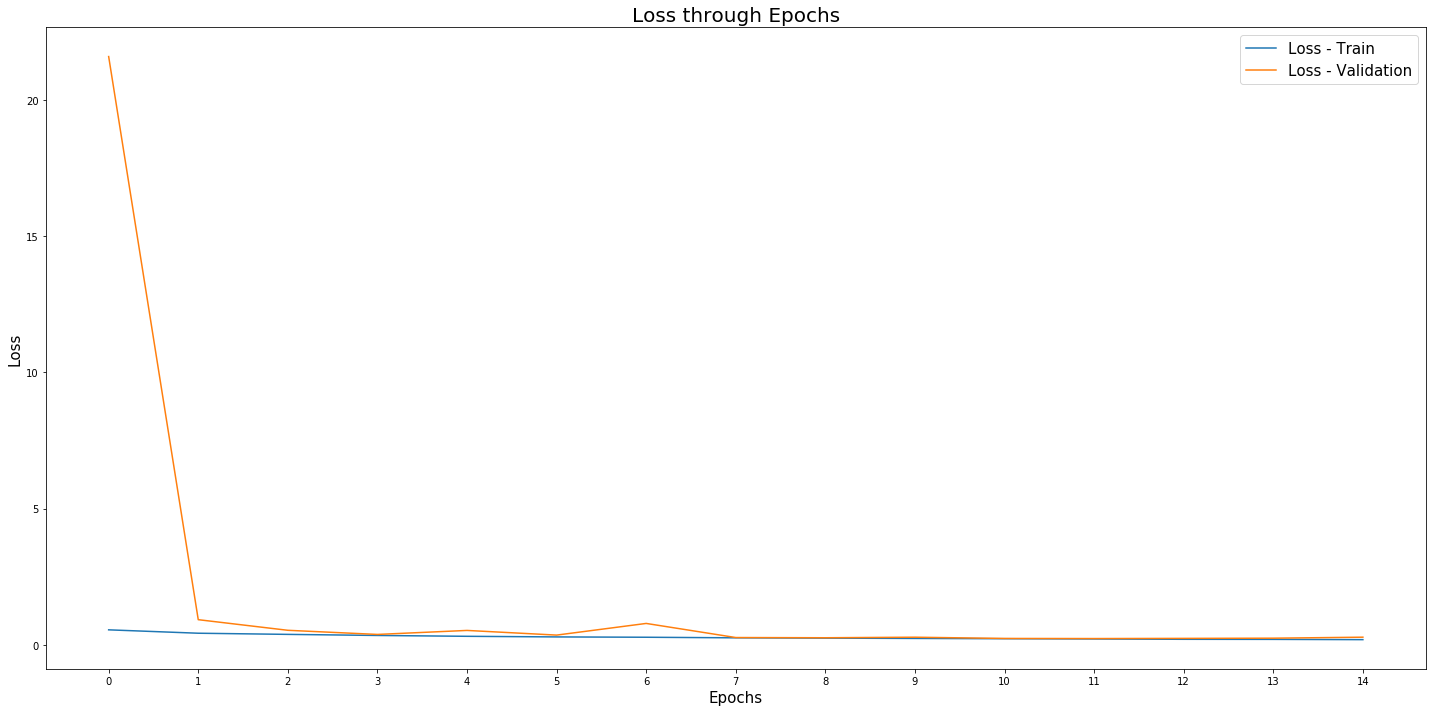

In [38]:
# Definir eixo x
epochs_range = list(range(0,EPOCHS))

# PLot - Loss
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes.plot(model_history.history['loss'], label='Loss - Train')
axes.plot(model_history.history['val_loss'], label='Loss - Validation')
axes.set_title('Loss through Epochs', fontsize=20)
axes.set_xlabel('Epochs', fontsize=15)
axes.set_ylabel('Loss', fontsize=15)
axes.set_xticks(epochs_range)
axes.legend(loc='upper right', fontsize=15)
plt.tight_layout()

### 2) Valor de Accuracy

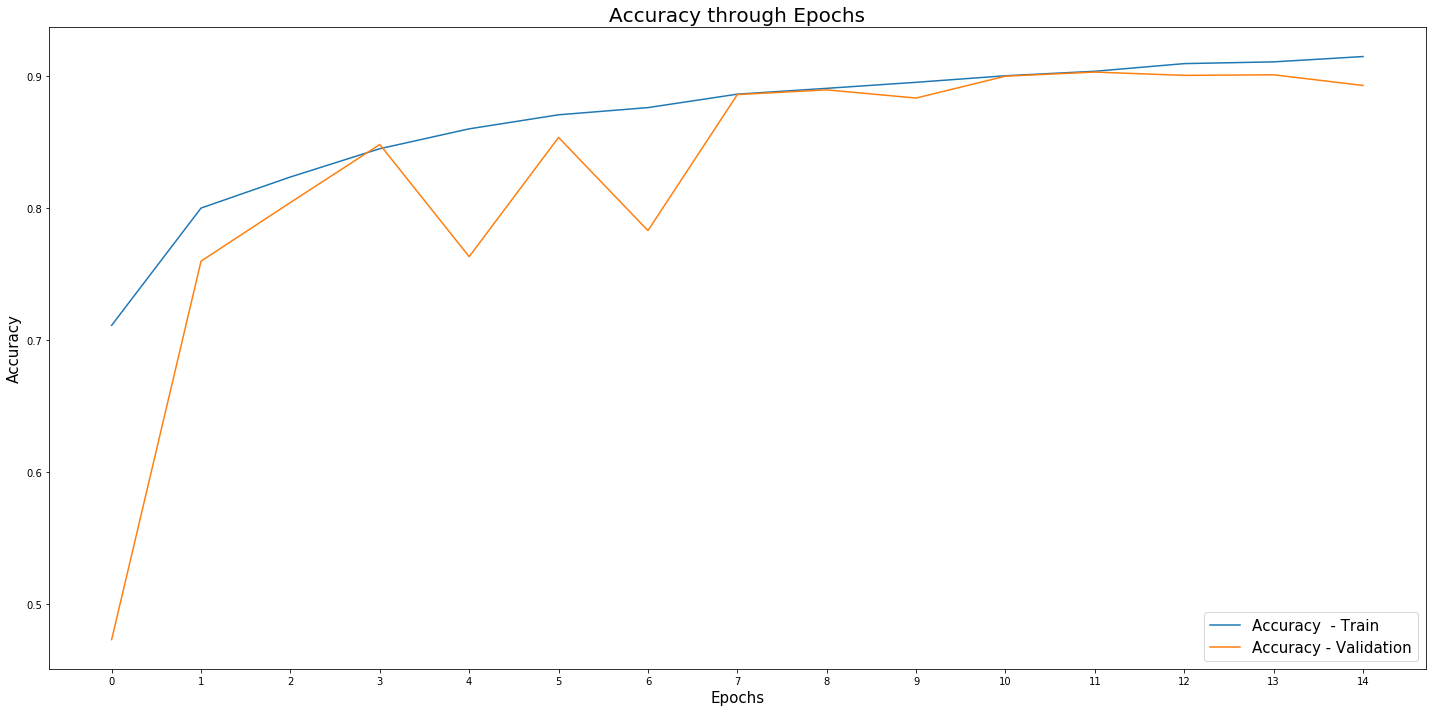

In [40]:
# PLot - Acc
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes.plot(model_history.history['accuracy'], label='Accuracy  - Train')
axes.plot(model_history.history['val_accuracy'], label='Accuracy - Validation')
axes.set_title('Accuracy through Epochs', fontsize=20)
axes.set_xlabel('Epochs', fontsize=15)
axes.set_ylabel('Accuracy', fontsize=15)
axes.set_xticks(epochs_range)
axes.legend(loc='lower right', fontsize=15)
plt.tight_layout()

## Predição da máscara Semântica

In [135]:
def show_segmentation_predictions(dataset, n_sample):
    '''
    Plota as imagens junto com as mascaras real e predita (args em ingles)
    Args:
        dataset: dataset to pick your sample
        n_sample: sample quantity to plot
    '''
    # Definir subgrid de plots
    fig, axes = plt.subplots(nrows=n_sample, ncols=4, figsize=(15, 15))
    plot_index = 0
    # Loop para prever uma mascara e plotar!
    for img, mask in dataset.unbatch().take(n_sample):
        # Prever
        pred_mask = unet_model.predict(x=tf.reshape(img, (1,128,128,3)))
        pred_mask = tf.reshape(pred_mask, (128,128,1))
        # Definir limite de confianca do modelo para o pixel
        pred_thresh_mask = tf.where((pred_mask  >= 0.8), 1, 0)        
        # Plot
        axes[plot_index][0].set_title('Image', fontsize=15)
        axes[plot_index][0].imshow(tf.keras.preprocessing.image.array_to_img(img))
        axes[plot_index][0].axis('off')
        axes[plot_index][1].set_title('Original', fontsize=15)
        axes[plot_index][1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
        axes[plot_index][1].axis('off')
        axes[plot_index][2].set_title('Predicted', fontsize=15)
        axes[plot_index][2].imshow(tf.keras.preprocessing.image.array_to_img(pred_mask))
        axes[plot_index][2].axis('off')
        axes[plot_index][3].set_title('Predicted >= 0.8', fontsize=15)
        axes[plot_index][3].imshow(tf.keras.preprocessing.image.array_to_img(pred_thresh_mask))
        axes[plot_index][3].axis('off')
        # Update index
        plot_index += 1

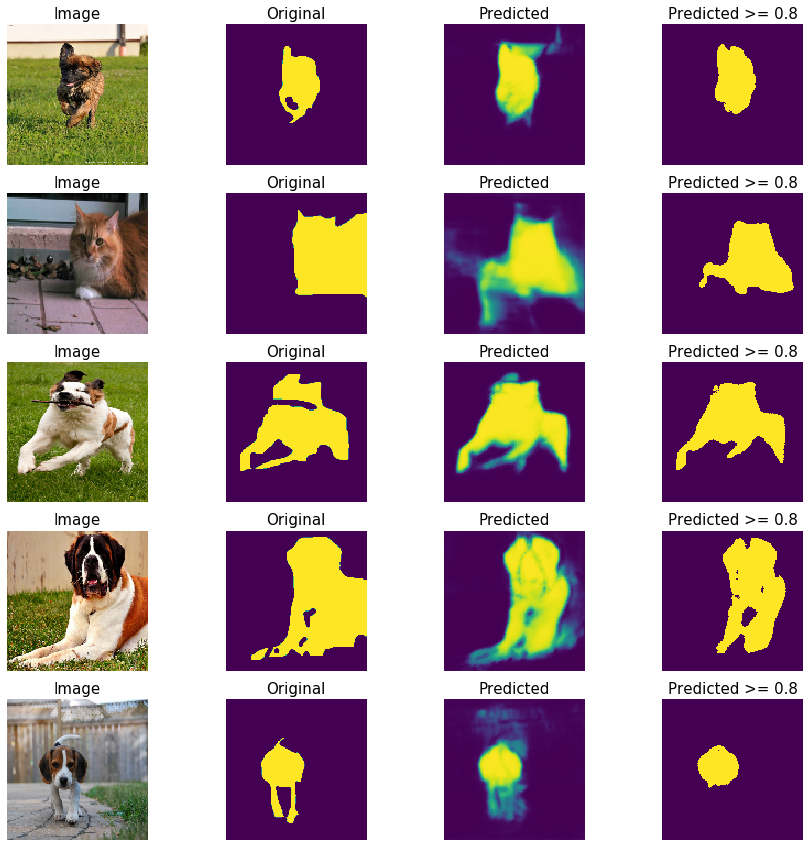

In [136]:
# Mostra os resultados
show_segmentation_predictions(dataset=test_dataset, n_sample=5)

# Avaliação qualitativa do modelo

**Link útil para entender esta parte**:[How to Visualize Filters and Feature Maps in Convolutional Neural Networks](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/).

## Visualização - Kernels (Filtros)

In [107]:
for layer in unet_model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name,': ', filters.shape)

conv2d :  (3, 3, 3, 16)
conv2d_1 :  (3, 3, 16, 16)
conv2d_2 :  (3, 3, 16, 32)
conv2d_3 :  (3, 3, 32, 32)
conv2d_4 :  (3, 3, 32, 64)
conv2d_5 :  (3, 3, 64, 64)
conv2d_6 :  (3, 3, 64, 128)
conv2d_7 :  (3, 3, 128, 128)
conv2d_8 :  (3, 3, 128, 256)
conv2d_9 :  (3, 3, 256, 256)
conv2d_10 :  (3, 3, 256, 128)
conv2d_11 :  (3, 3, 128, 128)
conv2d_12 :  (3, 3, 128, 64)
conv2d_13 :  (3, 3, 64, 64)
conv2d_14 :  (3, 3, 64, 32)
conv2d_15 :  (3, 3, 32, 32)
conv2d_16 :  (3, 3, 32, 16)
conv2d_17 :  (3, 3, 16, 16)
conv2d_18 :  (1, 1, 16, 1)


Dado o fato de que os primeiros filtros são mais fáceis para humanos compreender, apresentei as imagens dos kernels da primeira camada Convolucional:

In [112]:
# Camada para plot escolhida - Lembre que "0" representa Input Layer
chosen_layer = 1

# Pegar os pesos dos filtros da camada escolhida
filters, biases = unet_model.layers[chosen_layer].get_weights()

In [113]:
# Normalizar os valores do filtro para visualizarmos
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

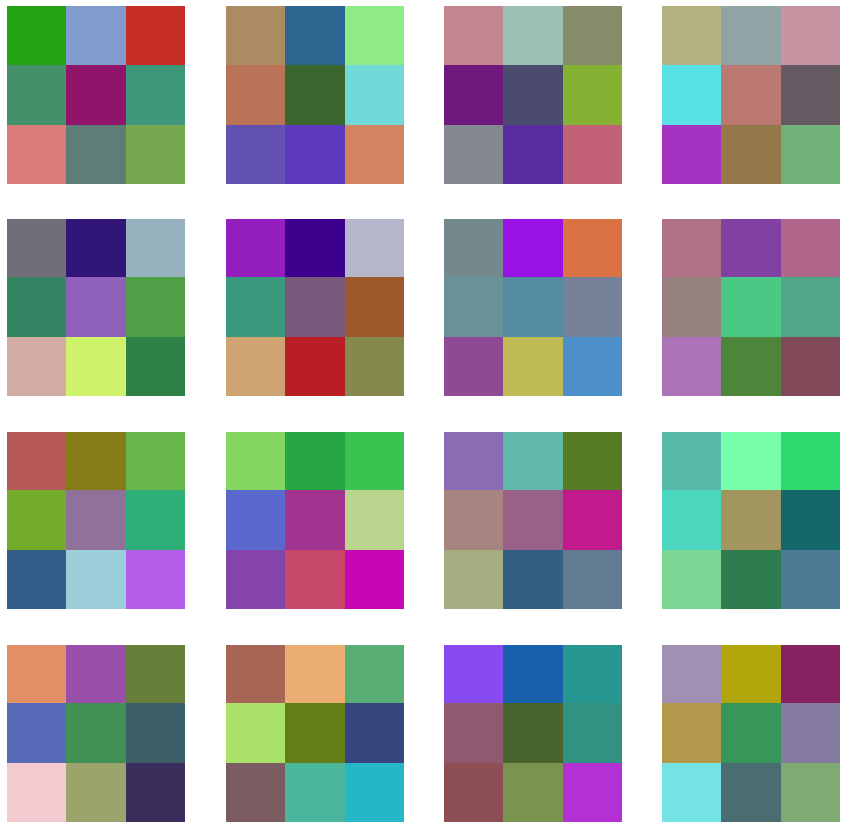

In [133]:
# Definir numero de filtros
n_filters = 16
# Criar grid de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
# Definir contadores para controlar aonde sera plotado
col = 0
row = 0
# Loop para pegar o filtro, reshape e plotar
for f in range(0, n_filters):
    # Pegar
    layer_filter = filters[:,:,:,f]
    # Reshape
    layer_filter = np.reshape(layer_filter, (3,3,3))
    # Plot
    ax[row][col].imshow(layer_filter)
    ax[row][col].axis('off')
    # Att contadores
    if row == 3:
        row = 0
        col += 1
    else:
        row += 1

## Visualização - Mapas de ativação

In [134]:
# Definir um novo "modelo" para pegar suas saídas (mapas)
unet_first_layer_model = Model(inputs=unet_model.inputs, outputs=unet_model.layers[1].output)

In [137]:
# Ver a quantidade de canais da saída (mapas de ativação)
unet_first_layer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_input_layer (InputLayer [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [141]:
# Prever um mapa de ativação que é basicamente pegar a saída deste novo "modelo"
for img, mask in test_dataset.unbatch().take(1):
    feature_maps = unet_first_layer_model.predict(tf.reshape(img, (1,128,128,3)))

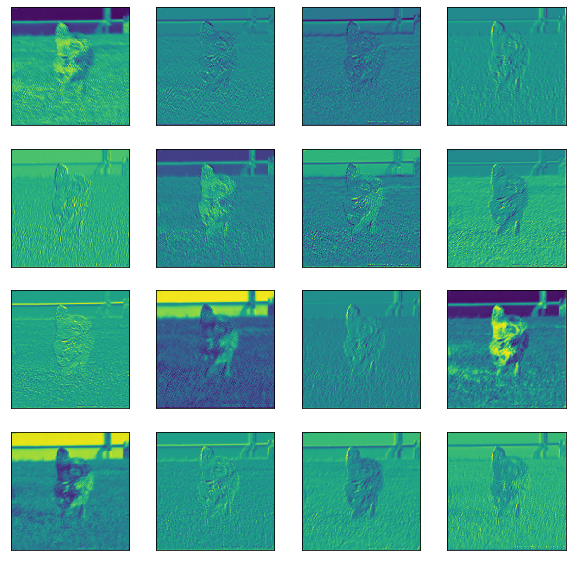

In [150]:
# Plot os mapas de ativação em um grid 4x4
square = 4
ix = 1
f = plt.figure(figsize=(10,10))
# Plot
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
plt.show()

# Conclusões
Através desses resultados, podemos afirmar que:
- No geral, a UNet mostrou bons resultados com uma acurácia de 90%
- O processo de treinamento ocorreu como esperado, sem a presença de *overfitting*
- A visualização dos filtros não forneceu nenhuma informação útil colorida. Talvez em preto e branco seria possível visualizar bordas e etc.
- A visualização dos mapas de ativação mostrou que pelo menos na primeira camada não apresenta "unidades mortas" (possível problema da função de ativação ReLU).